# 🛰️ Exploratory Data Analysis & Visualization — Hyperspectral Imagery

**Purpose:** Comprehensive EDA of the Indian Pines benchmark HSI dataset.
This notebook serves as the analytical foundation for subsequent notebooks on
dimensionality reduction, spatial autocorrelation, and feature engineering.

---

## Table of Contents
0. **Setup & Data Loading**
1. **Ground Truth & Spectral Signatures**
2. **Band Visualization & False-Color Composites**
3. **Key Statistics, Class Distribution & Imbalance Analysis**
4. **Advanced Techniques** (SNR, PCA, t-SNE, Moran's I, Spectral Derivatives, JM Distance)

---
## 0 · Setup & Data Loading

In [1]:
# ── Imports ──────────────────────────────────────────────────────────────────
import sys, os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.io as sio
import scipy.ndimage as ndimage
from scipy.spatial.distance import pdist, squareform
from scipy.stats import skew, kurtosis, entropy

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Project-level imports
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.data.hsi_loader import load_benchmark_dataset, HSICube

# Plotting defaults
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "font.size": 10,
    "figure.facecolor": "white",
})
sns.set_style("whitegrid")

print("✅ All imports successful.")

✅ All imports successful.


## Part A : Pavia University

In [3]:
# ── Load Indian Pines dataset ───────────────────────────────────────────────
DATA_DIR = os.path.join(PROJECT_ROOT, "data", "external", "pavia_university")

cube: HSICube = load_benchmark_dataset("pavia_university", DATA_DIR)

X   = cube.data            # (H, W, B)  — reflectance cube
gt  = cube.ground_truth    # (H, W)     — class labels  (0 = background)
class_names = cube.class_names  # List[str] including "Background"

H, W, B = X.shape
n_classes = cube.n_classes  # excludes background

print(f"{'─'*55}")
print(f"  Dataset          : Indian Pines (corrected)")
print(f"  Spatial size     : {H} × {W}  ({cube.n_pixels:,} pixels)")
print(f"  Spectral bands   : {B}")
print(f"  Classes          : {n_classes}  (+ background)")
print(f"  Data dtype       : {X.dtype}")
print(f"  Memory footprint : {X.nbytes / 1024**2:.1f} MB")
print(f"  Value range      : [{X.min():.1f}, {X.max():.1f}]")
print(f"  Mean reflectance : {X.mean():.2f}")
print(f"{'─'*55}")

/Users/ashutoshbaruah/Documents/dev/THESIS-HSI-Classification/data/external/pavia_university/PaviaU.mat
Filepath : /Users/ashutoshbaruah/Documents/dev/THESIS-HSI-Classification/data/external/pavia_university/PaviaU.mat


error: Error -3 while decompressing data: incorrect data check

---
### 1 · Ground Truth & Spectral Signatures

#### 1.1 — Ground Truth Classification Map

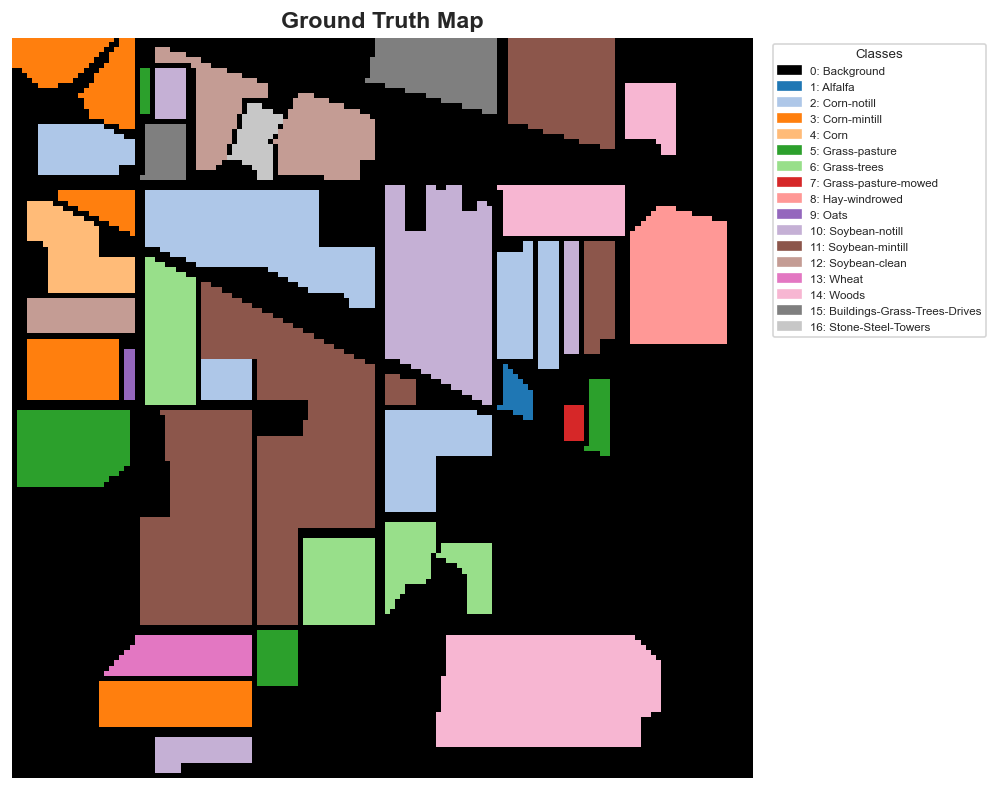

In [12]:
def plot_ground_truth(gt, class_names, title="Ground Truth Map"):
    """Render ground truth with a discrete, perceptually distinct colormap."""
    unique_labels = np.unique(gt)
    n_labels = len(unique_labels)

    # Build colormap: black for background, tab20 for classes
    base_colors = plt.cm.tab20(np.linspace(0, 1, 20))
    colors = np.vstack([[[0, 0, 0, 1]], base_colors[:n_labels - 1]])
    cmap = mcolors.ListedColormap(colors)
    bounds = np.arange(-0.5, n_labels + 0.5, 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(gt, cmap=cmap, norm=norm, interpolation="nearest")
    ax.set_title(title, fontweight="bold", fontsize=14)
    ax.axis("off")

    # Legend
    patches = [mpatches.Patch(color=colors[i], label=f"{unique_labels[i]}: {class_names[i]}")
               for i in range(n_labels)]
    ax.legend(handles=patches, bbox_to_anchor=(1.02, 1), loc="upper left",
              fontsize=7, frameon=True, title="Classes", title_fontsize=8)

    plt.tight_layout()
    plt.show()

plot_ground_truth(gt, class_names)

#### 1.2 — Single-Pixel Spectral Signature

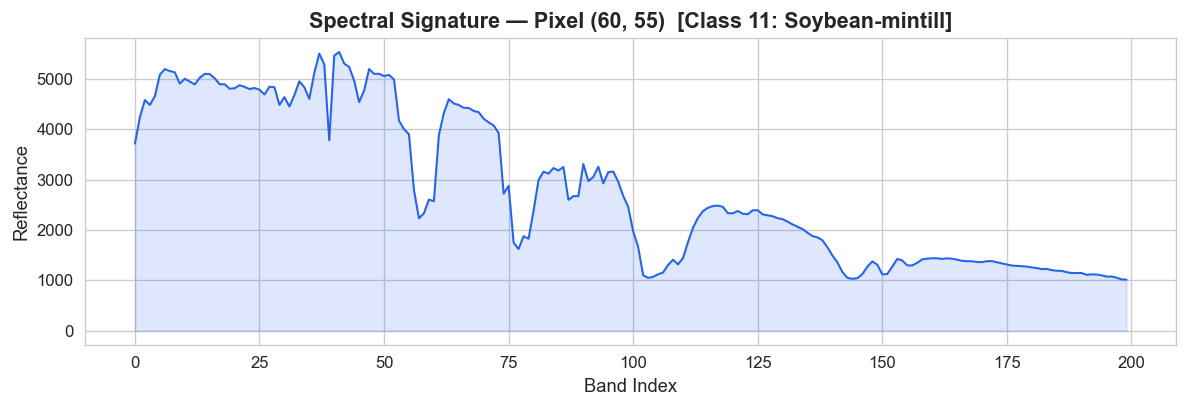

In [13]:
def plot_single_pixel_signature(X, row, col, band_axis_label="Band Index"):
    """Plot the reflectance spectrum for a single pixel."""
    spectrum = X[row, col, :]
    fig, ax = plt.subplots(figsize=(10, 3.5))
    ax.plot(np.arange(len(spectrum)), spectrum, color="#2563EB", linewidth=1.2)
    ax.fill_between(np.arange(len(spectrum)), spectrum, alpha=0.15, color="#2563EB")
    ax.set_xlabel(band_axis_label)
    ax.set_ylabel("Reflectance")
    ax.set_title(f"Spectral Signature — Pixel ({row}, {col})  "
                 f"[Class {gt[row, col]}: {class_names[gt[row, col]]}]",
                 fontweight="bold")
    plt.tight_layout()
    plt.show()

# Choose a labeled pixel (not background)
labeled_rows, labeled_cols = np.where(gt > 0)
sample_idx = len(labeled_rows) // 2  # pick a pixel from the middle
plot_single_pixel_signature(X, labeled_rows[sample_idx], labeled_cols[sample_idx])

#### 1.3 — Per-Class Mean Spectral Signatures (with ± 1 σ)

In [14]:
def compute_class_spectra(X, gt, class_names):
    """Return per-class mean and std spectral profiles."""
    records = {}
    for c in range(1, len(class_names)):  # skip background
        mask = gt == c
        if mask.sum() == 0:
            continue
        pixels = X[mask]  # (n_pixels_in_class, B)
        records[c] = {
            "name": class_names[c],
            "mean": pixels.mean(axis=0),
            "std": pixels.std(axis=0),
            "count": int(mask.sum()),
        }
    return records

class_spectra = compute_class_spectra(X, gt, class_names)

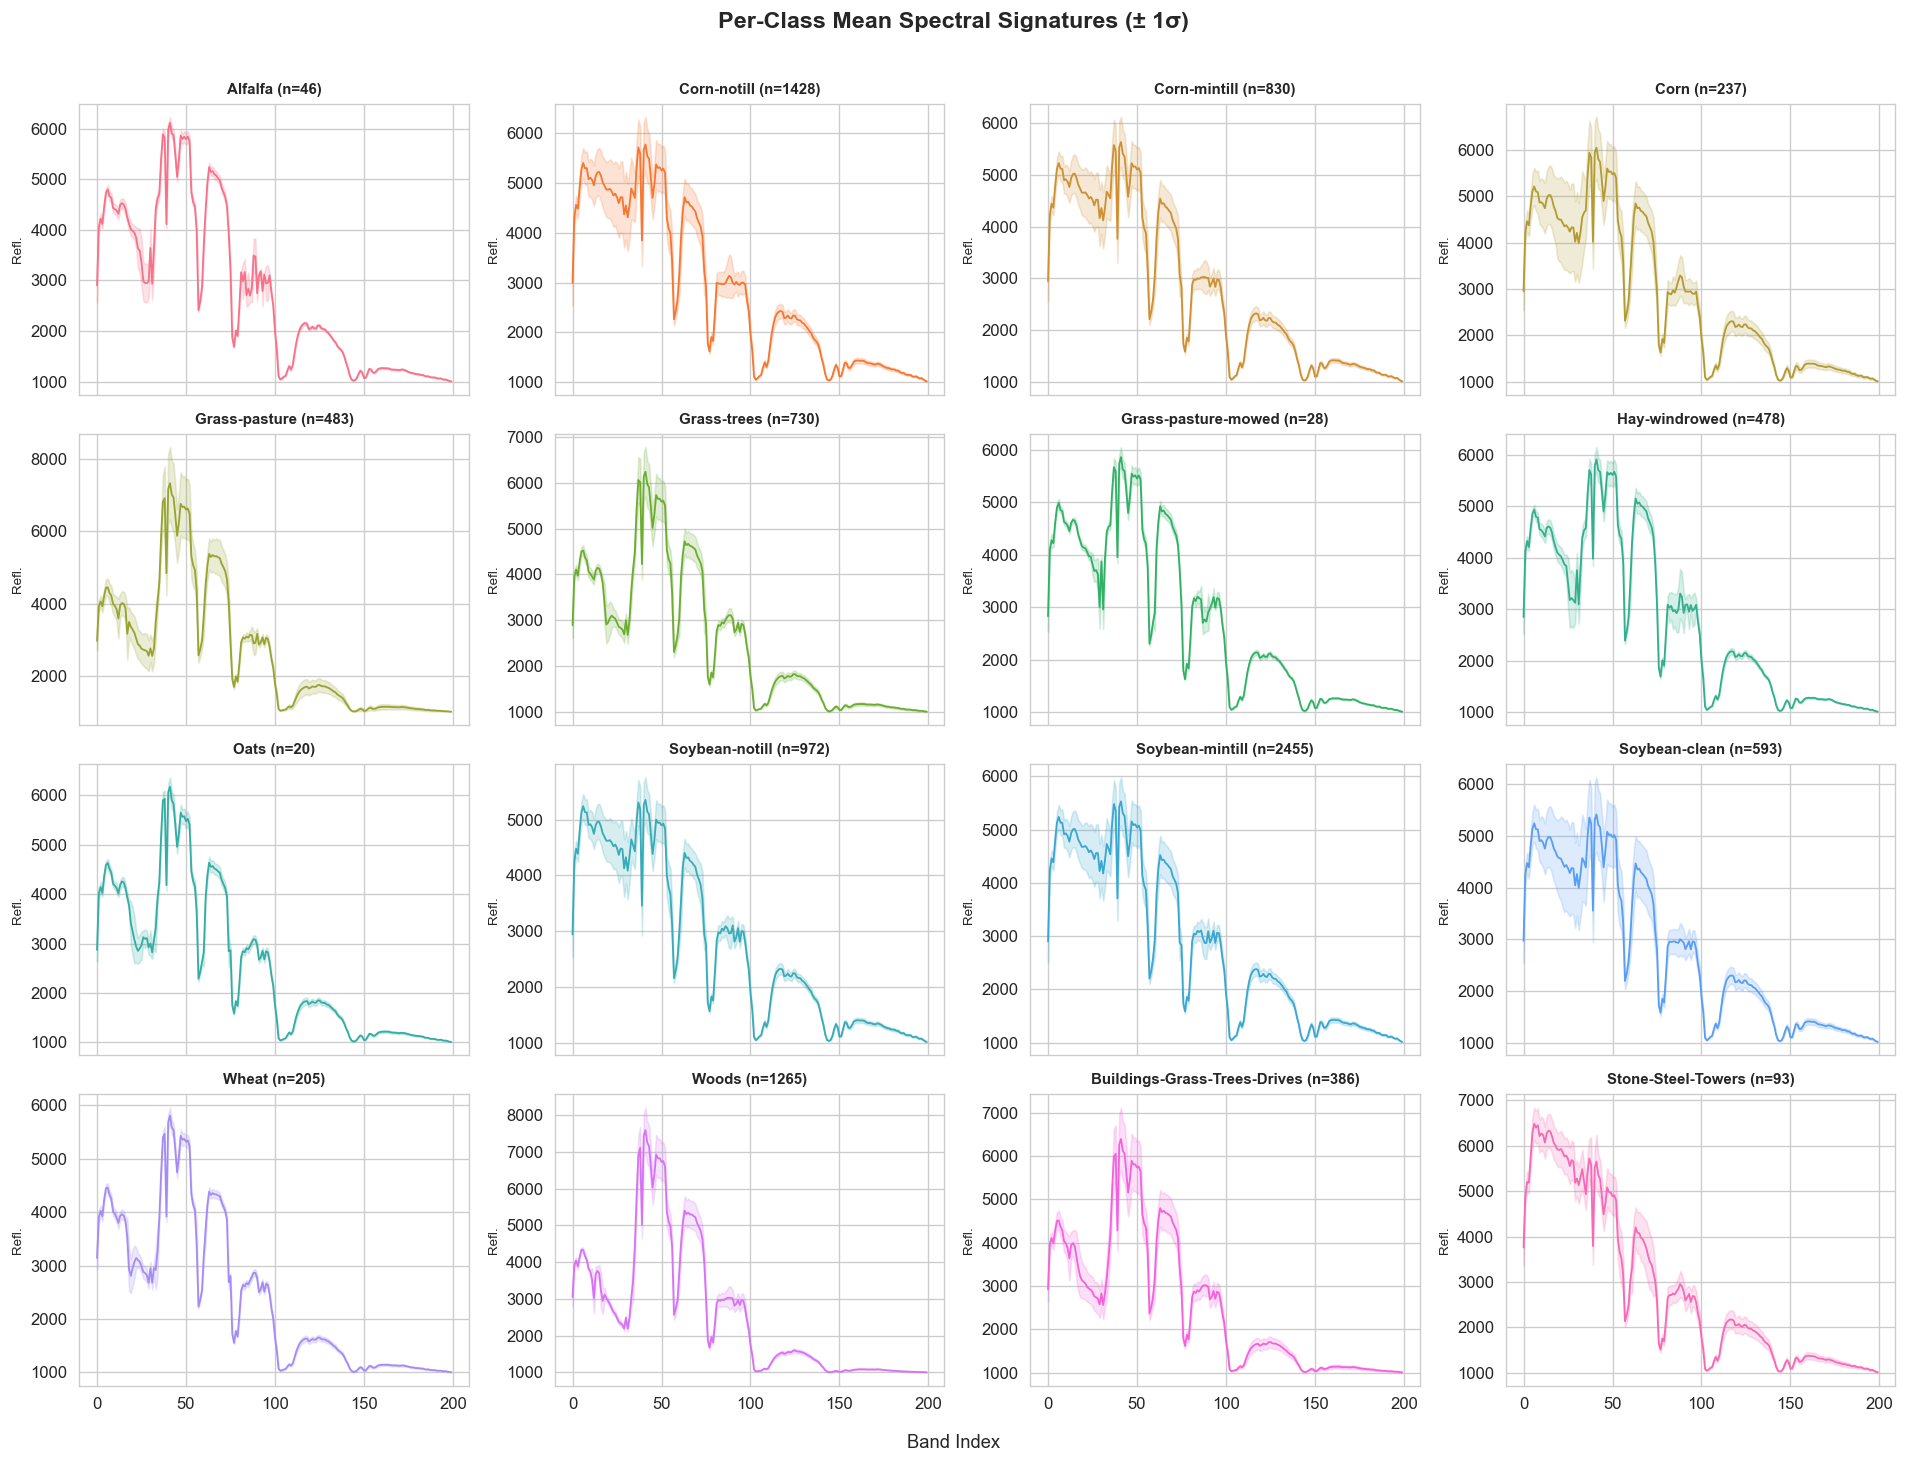

In [15]:
def plot_mean_spectral_signatures(class_spectra, ncols=4):
    """Grid of per-class mean ± std spectral profiles."""
    n = len(class_spectra)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=True)
    axes = np.atleast_2d(axes)
    palette = sns.color_palette("husl", n)

    for idx, (c, info) in enumerate(class_spectra.items()):
        ax = axes[idx // ncols, idx % ncols]
        bands = np.arange(len(info["mean"]))
        ax.plot(bands, info["mean"], color=palette[idx], linewidth=1.1)
        ax.fill_between(bands, info["mean"] - info["std"],
                        info["mean"] + info["std"],
                        color=palette[idx], alpha=0.2)
        ax.set_title(f'{info["name"]} (n={info["count"]})', fontsize=9, fontweight="bold")
        ax.set_ylabel("Refl.", fontsize=8)

    # Hide unused subplots
    for idx in range(n, nrows * ncols):
        axes[idx // ncols, idx % ncols].set_visible(False)

    fig.supxlabel("Band Index", fontsize=11)
    fig.suptitle("Per-Class Mean Spectral Signatures (± 1σ)", fontsize=14, fontweight="bold", y=1.01)
    plt.tight_layout()
    plt.show()

plot_mean_spectral_signatures(class_spectra)

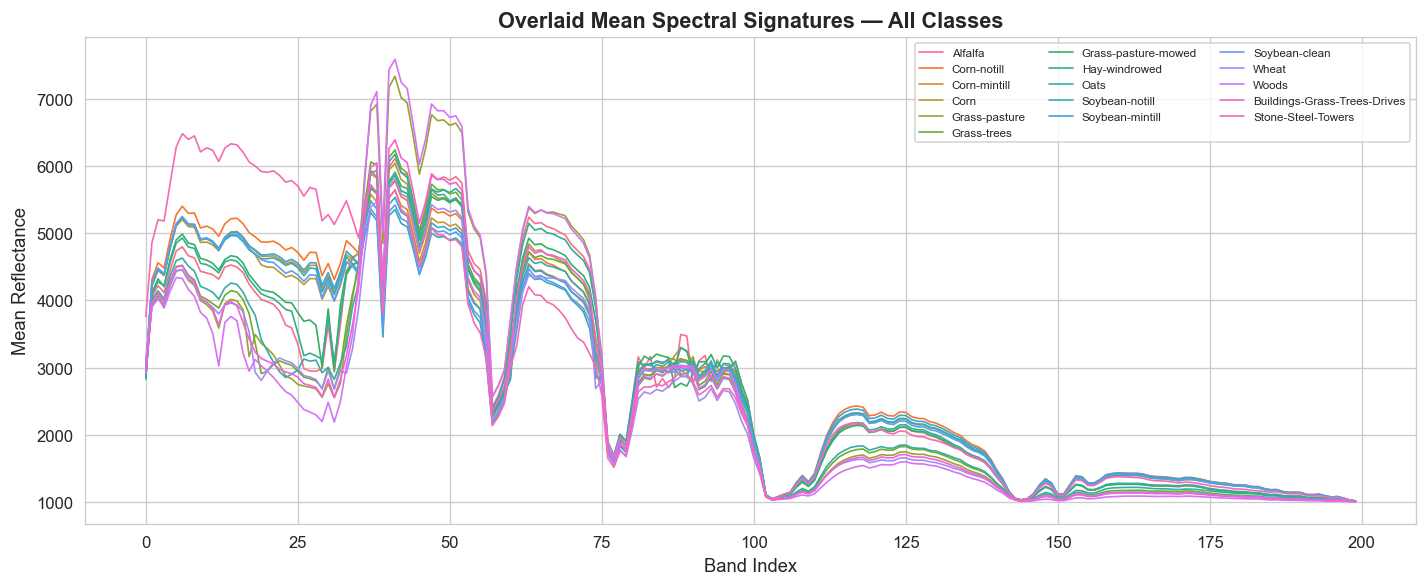

In [16]:
# Overlay plot of all class means on a single axis
def plot_overlay_signatures(class_spectra):
    """All class mean signatures overlaid for quick comparison."""
    fig, ax = plt.subplots(figsize=(12, 5))
    palette = sns.color_palette("husl", len(class_spectra))
    for idx, (c, info) in enumerate(class_spectra.items()):
        ax.plot(info["mean"], color=palette[idx], linewidth=1.0, label=info["name"])
    ax.set_xlabel("Band Index")
    ax.set_ylabel("Mean Reflectance")
    ax.set_title("Overlaid Mean Spectral Signatures — All Classes", fontweight="bold")
    ax.legend(fontsize=7, ncol=3, loc="upper right", frameon=True)
    plt.tight_layout()
    plt.show()

plot_overlay_signatures(class_spectra)

#### 1.4 — Spectral Separability Matrix (Spectral Angle Mapper)

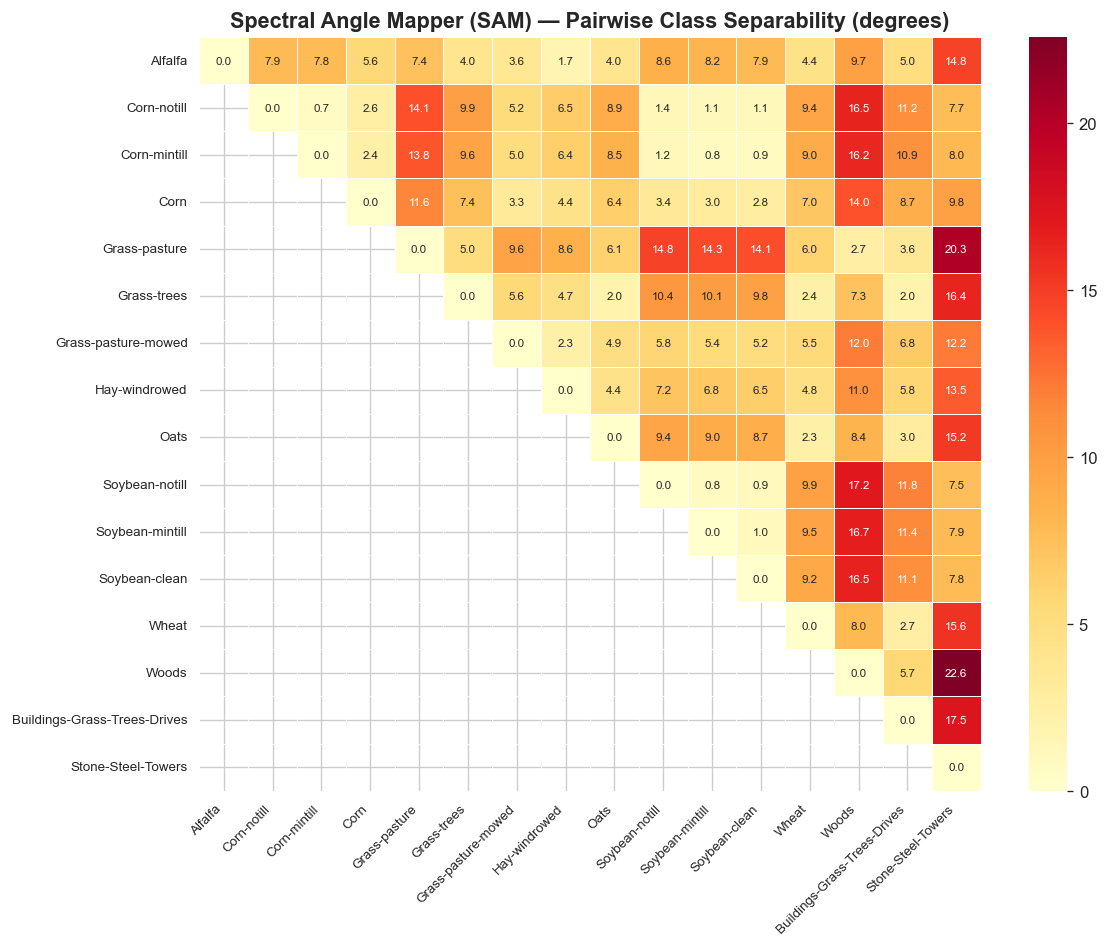

In [17]:
def spectral_angle(a, b):
    """Compute spectral angle (radians) between two spectra."""
    cos_theta = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-12)
    return np.arccos(np.clip(cos_theta, -1, 1))

def sam_separability_matrix(class_spectra):
    """Build pairwise SAM distance matrix between class centroids."""
    labels = list(class_spectra.keys())
    names = [class_spectra[c]["name"] for c in labels]
    n = len(labels)
    mat = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            angle = spectral_angle(class_spectra[labels[i]]["mean"],
                                   class_spectra[labels[j]]["mean"])
            mat[i, j] = mat[j, i] = np.degrees(angle)
    return mat, names

sam_mat, sam_names = sam_separability_matrix(class_spectra)

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(sam_mat, dtype=bool), k=1)
sns.heatmap(sam_mat, annot=True, fmt=".1f", mask=~mask & ~np.eye(len(sam_mat), dtype=bool),
            xticklabels=sam_names, yticklabels=sam_names,
            cmap="YlOrRd", ax=ax, linewidths=0.5, vmin=0,
            annot_kws={"fontsize": 7})
ax.set_title("Spectral Angle Mapper (SAM) — Pairwise Class Separability (degrees)",
             fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

---
### 2 · Band Visualization & False-Color Composites

#### 2.1 — Selected Individual Bands

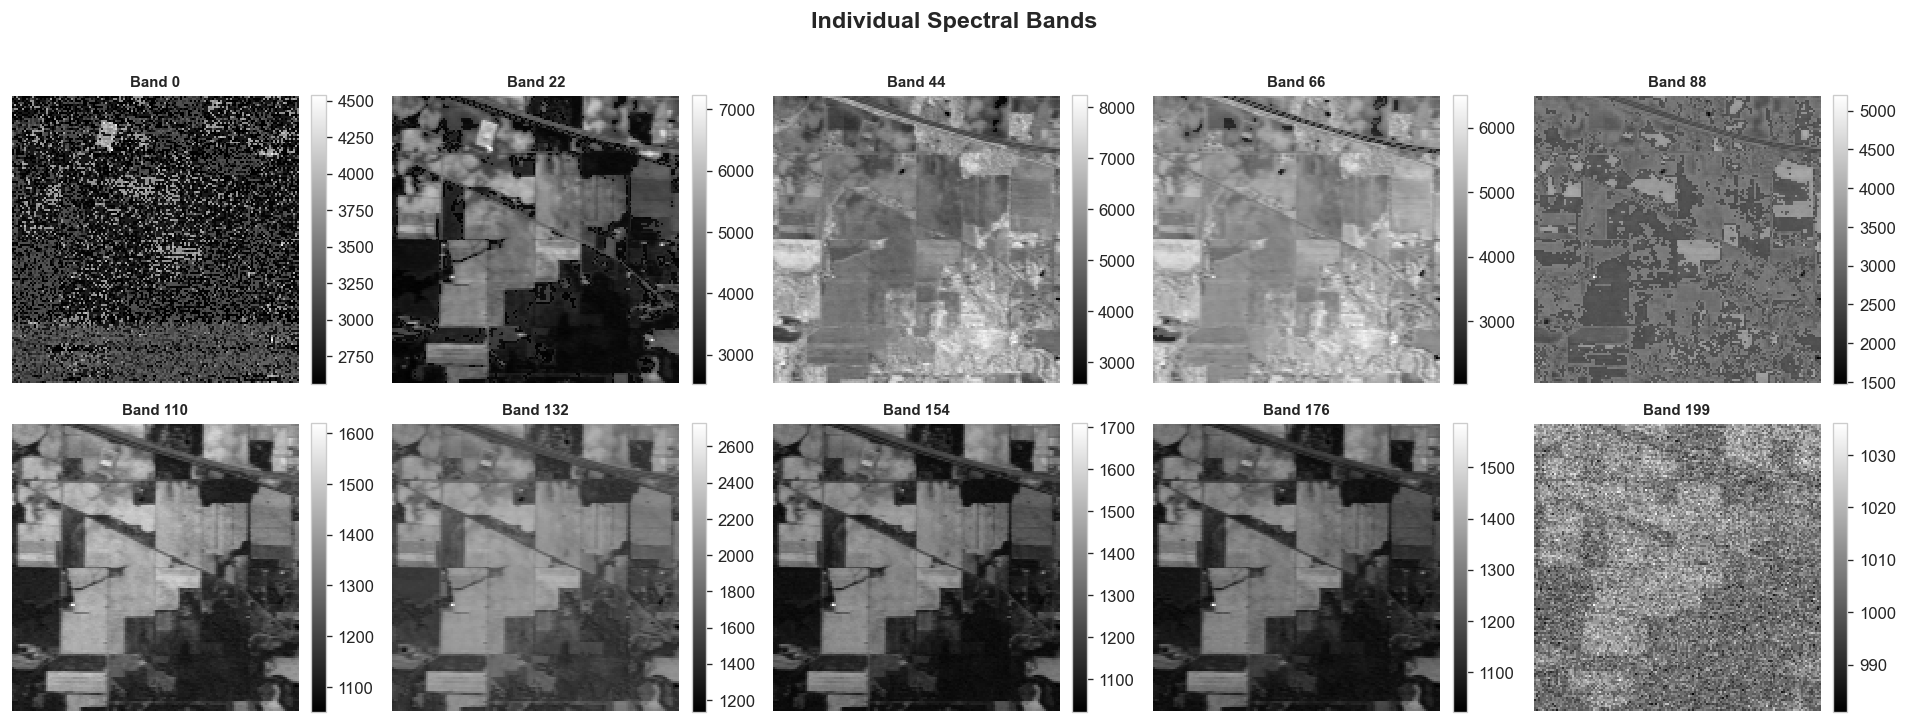

In [18]:
def plot_band_grid(X, band_indices, ncols=5, cmap="gray"):
    """Display a grid of individual bands."""
    n = len(band_indices)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2 * ncols, 3 * nrows))
    axes = np.atleast_2d(axes)
    for idx, b in enumerate(band_indices):
        ax = axes[idx // ncols, idx % ncols]
        im = ax.imshow(X[:, :, b], cmap=cmap, interpolation="nearest")
        ax.set_title(f"Band {b}", fontsize=9, fontweight="bold")
        ax.axis("off")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    for idx in range(n, nrows * ncols):
        axes[idx // ncols, idx % ncols].set_visible(False)
    fig.suptitle("Individual Spectral Bands", fontsize=14, fontweight="bold", y=1.01)
    plt.tight_layout()
    plt.show()

# Sample every ~40 bands across the spectrum
selected_bands = np.linspace(0, B - 1, 10, dtype=int)
plot_band_grid(X, selected_bands, ncols=5)

#### 2.2 — False-Color Composites (RGB from Band Triplets)

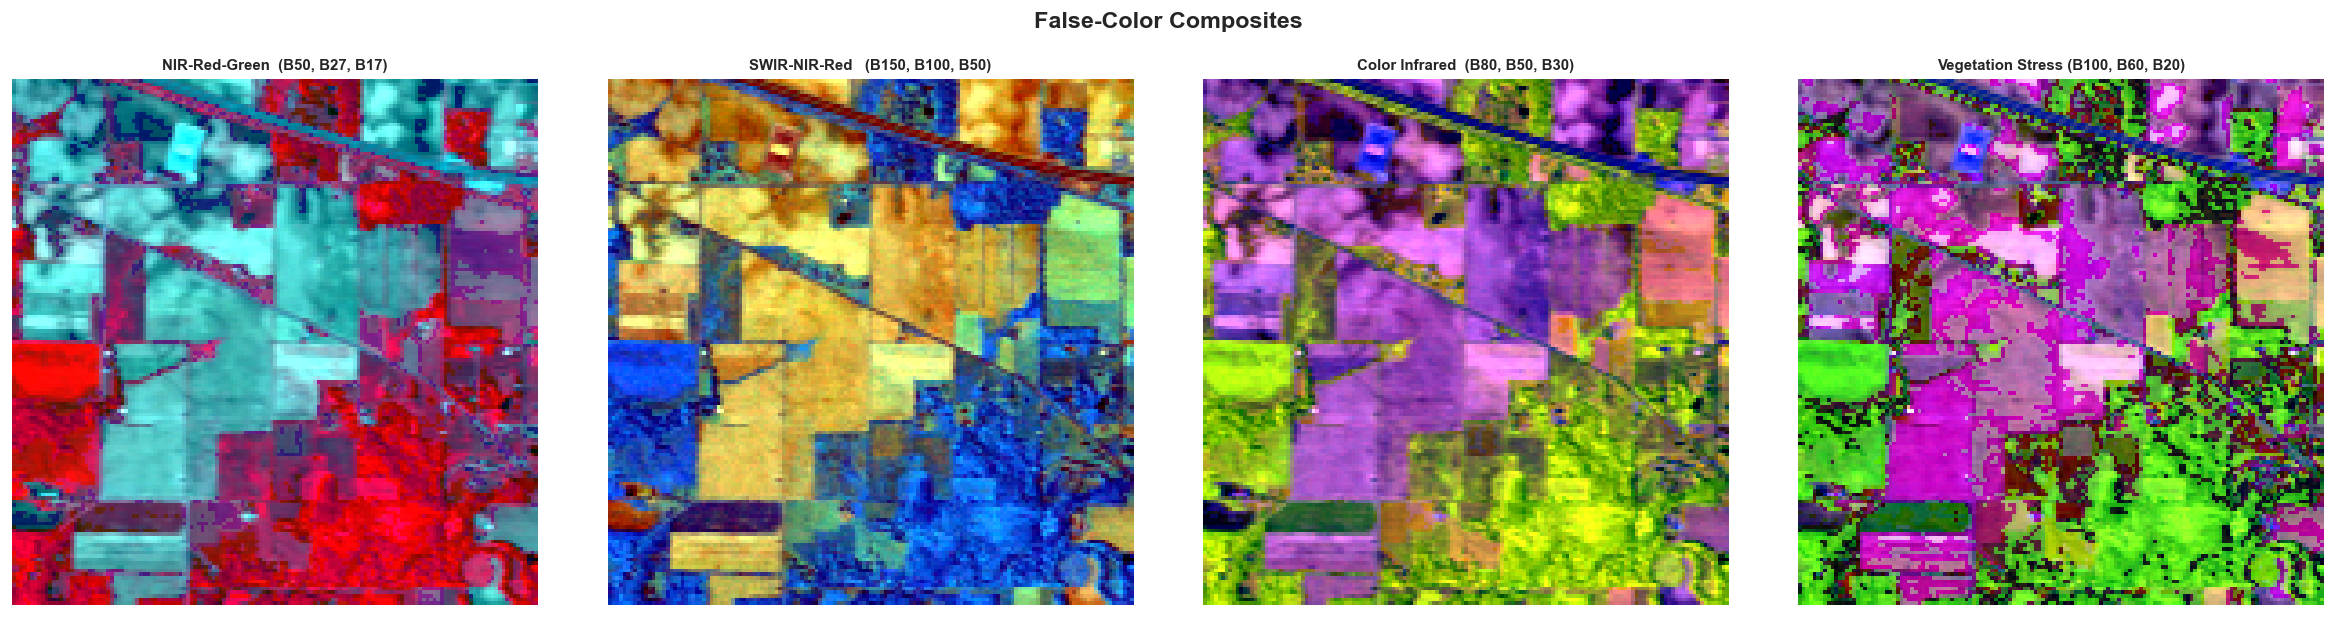

In [19]:
def false_color_composite(X, r, g, b, percentile_stretch=(2, 98)):
    """Create a false-color RGB image from three bands with percentile stretching."""
    rgb = np.stack([X[:, :, r], X[:, :, g], X[:, :, b]], axis=-1).astype(np.float64)
    for ch in range(3):
        lo, hi = np.percentile(rgb[:, :, ch], percentile_stretch)
        rgb[:, :, ch] = np.clip((rgb[:, :, ch] - lo) / (hi - lo + 1e-8), 0, 1)
    return rgb

composites = {
    "NIR-Red-Green  (B50, B27, B17)": (50, 27, 17),
    "SWIR-NIR-Red   (B150, B100, B50)": (150, 100, 50),
    "Color Infrared  (B80, B50, B30)": (80, 50, 30),
    "Vegetation Stress (B100, B60, B20)": (100, 60, 20),
}

fig, axes = plt.subplots(1, len(composites), figsize=(5 * len(composites), 5))
for ax, (label, (r, g, b_)) in zip(axes, composites.items()):
    rgb_img = false_color_composite(X, r, g, b_)
    ax.imshow(rgb_img)
    ax.set_title(label, fontsize=9, fontweight="bold")
    ax.axis("off")
fig.suptitle("False-Color Composites", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

#### 2.3 — Band-Level Statistics Across the Spectrum

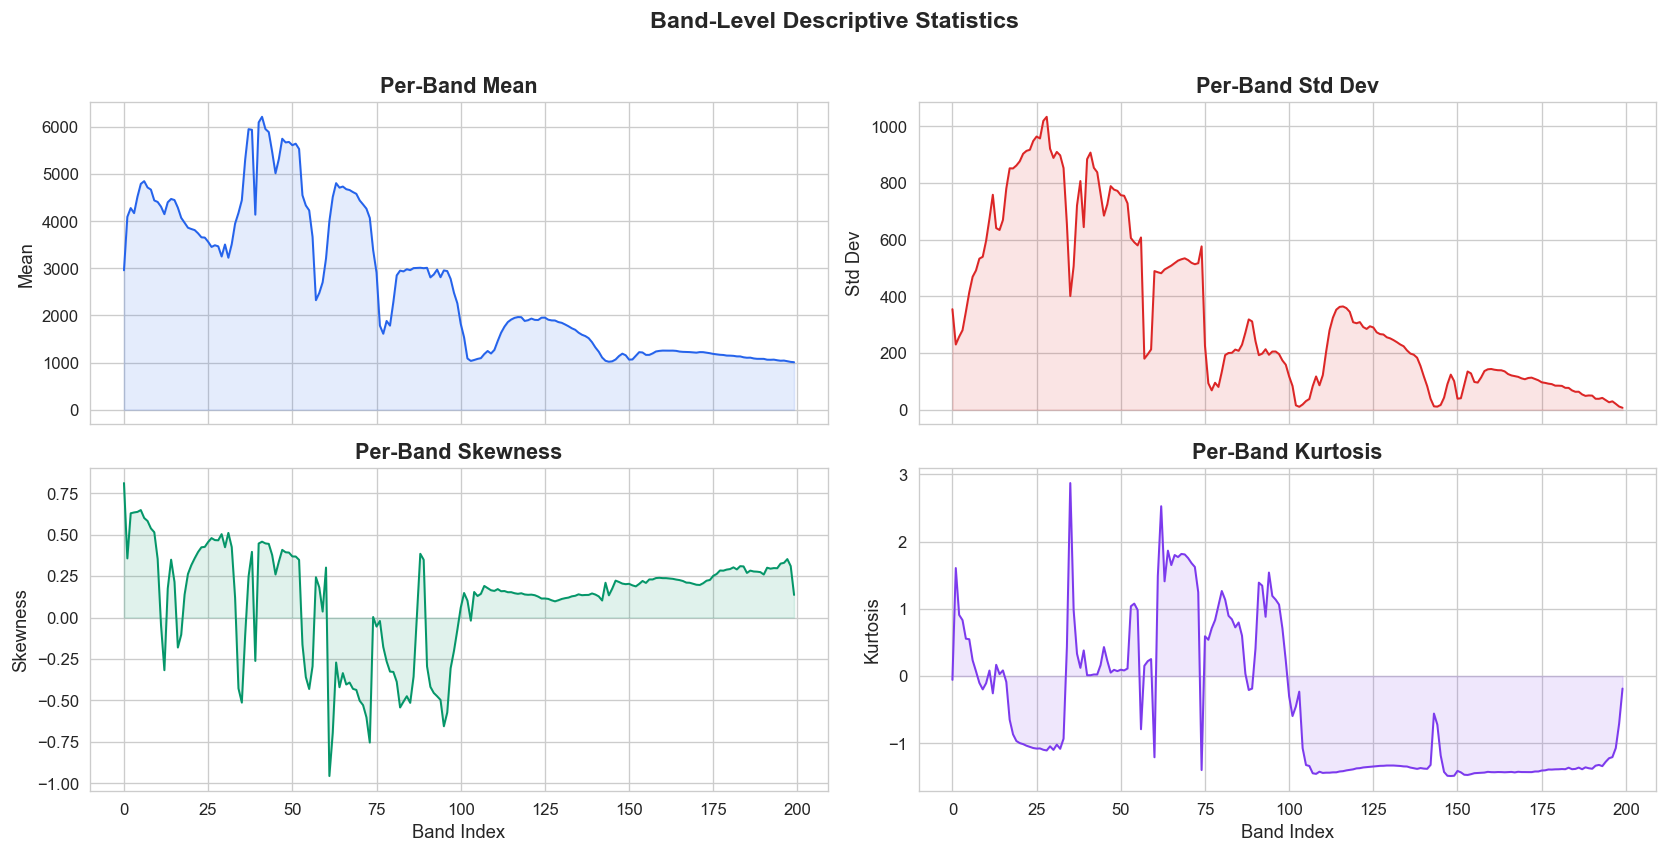

In [20]:
def plot_band_statistics(X):
    """Line plots of per-band mean, std, skewness, kurtosis."""
    flat = X.reshape(-1, X.shape[2])  # (N, B)
    band_means = flat.mean(axis=0)
    band_stds  = flat.std(axis=0)
    band_skew  = skew(flat, axis=0)
    band_kurt  = kurtosis(flat, axis=0)

    fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True)
    bands = np.arange(X.shape[2])

    for ax, data, label, color in zip(
            axes.flat,
            [band_means, band_stds, band_skew, band_kurt],
            ["Mean", "Std Dev", "Skewness", "Kurtosis"],
            ["#2563EB", "#DC2626", "#059669", "#7C3AED"]):
        ax.plot(bands, data, color=color, linewidth=1.2)
        ax.fill_between(bands, data, alpha=0.12, color=color)
        ax.set_ylabel(label)
        ax.set_title(f"Per-Band {label}", fontweight="bold")

    axes[1, 0].set_xlabel("Band Index")
    axes[1, 1].set_xlabel("Band Index")
    fig.suptitle("Band-Level Descriptive Statistics", fontsize=14, fontweight="bold", y=1.01)
    plt.tight_layout()
    plt.show()

plot_band_statistics(X)

---
### 3 · Key Statistics, Class Distribution & Imbalance Analysis

#### 3.1 — Class Distribution

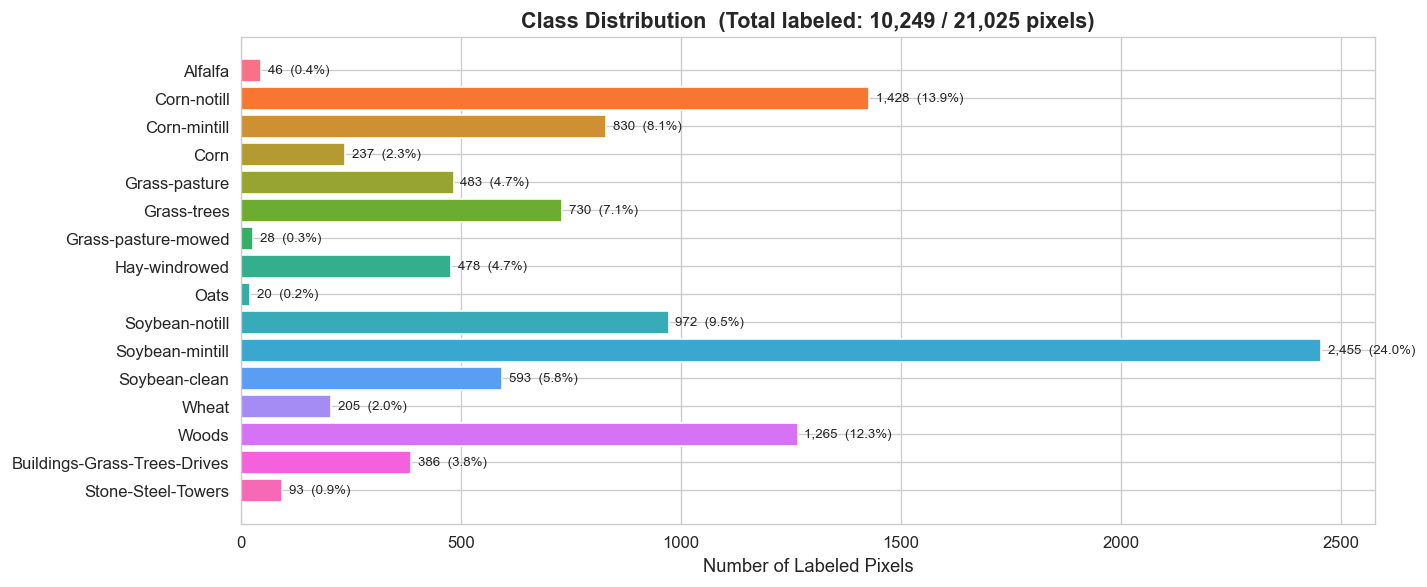

In [21]:
def plot_class_distribution(gt, class_names):
    """Bar chart of per-class sample counts."""
    unique, counts = np.unique(gt, return_counts=True)
    # Exclude background
    mask = unique > 0
    unique, counts = unique[mask], counts[mask]
    names = [class_names[u] for u in unique]

    total_labeled = counts.sum()
    pcts = counts / total_labeled * 100

    fig, ax = plt.subplots(figsize=(12, 5))
    bars = ax.barh(names, counts, color=sns.color_palette("husl", len(names)), edgecolor="white")

    for bar, pct, cnt in zip(bars, pcts, counts):
        ax.text(bar.get_width() + 15, bar.get_y() + bar.get_height() / 2,
                f"{cnt:,}  ({pct:.1f}%)", va="center", fontsize=8)

    ax.set_xlabel("Number of Labeled Pixels")
    ax.set_title(f"Class Distribution  (Total labeled: {total_labeled:,} / {gt.size:,} pixels)",
                 fontweight="bold", fontsize=13)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_class_distribution(gt, class_names)

#### 3.2 — Imbalance Metrics

In [22]:
def compute_imbalance_metrics(gt, class_names):
    """Quantify class imbalance using multiple metrics."""
    unique, counts = np.unique(gt, return_counts=True)
    mask = unique > 0
    unique, counts = unique[mask], counts[mask]

    max_count = counts.max()
    min_count = counts.min()
    imbalance_ratio = max_count / min_count

    # Shannon entropy (normalized)
    probs = counts / counts.sum()
    H = entropy(probs, base=2)
    H_max = np.log2(len(counts))
    H_norm = H / H_max  # 1.0 = perfectly balanced

    # Effective number of classes (exponential of entropy)
    eff_classes = 2 ** H

    # Build summary dataframe
    df = pd.DataFrame({
        "Class": [class_names[u] for u in unique],
        "Label": unique,
        "Count": counts,
        "Percentage": np.round(probs * 100, 2),
        "IR (vs. max)": np.round(max_count / counts, 1),
    })
    df = df.sort_values("Count", ascending=False).reset_index(drop=True)

    print(f"{'─'*55}")
    print(f"  Imbalance Ratio (max/min)    : {imbalance_ratio:.1f}×")
    print(f"  Shannon Entropy (bits)       : {H:.3f}  /  {H_max:.3f}")
    print(f"  Normalized Entropy           : {H_norm:.3f}  (1.0 = balanced)")
    print(f"  Effective # Classes          : {eff_classes:.1f}  /  {len(counts)}")
    print(f"  Minority class               : {class_names[unique[np.argmin(counts)]]} ({min_count})")
    print(f"  Majority class               : {class_names[unique[np.argmax(counts)]]} ({max_count})")
    print(f"{'─'*55}")
    return df

imbalance_df = compute_imbalance_metrics(gt, class_names)
imbalance_df

───────────────────────────────────────────────────────
  Imbalance Ratio (max/min)    : 122.8×
  Shannon Entropy (bits)       : 3.356  /  4.000
  Normalized Entropy           : 0.839  (1.0 = balanced)
  Effective # Classes          : 10.2  /  16
  Minority class               : Oats (20)
  Majority class               : Soybean-mintill (2455)
───────────────────────────────────────────────────────


,Class,Label,Count,Percentage,IR (vs. max)
0,Soybean-mintill,11,2455,23.95,1.0
1,Corn-notill,2,1428,13.93,1.7
2,Woods,14,1265,12.34,1.9
3,Soybean-notill,10,972,9.48,2.5
4,Corn-mintill,3,830,8.10,3.0
5,Grass-trees,6,730,7.12,3.4
6,Soybean-clean,12,593,5.79,4.1
7,Grass-pasture,5,483,4.71,5.1
8,Hay-windrowed,8,478,4.66,5.1
9,Buildings-Grass-Trees-Drives,15,386,3.77,6.4


#### 3.3 — Per-Class Summary Statistics Table

In [23]:
def build_class_statistics_table(X, gt, class_names):
    """Comprehensive per-class statistical summary."""
    rows = []
    for c in range(1, len(class_names)):
        mask = gt == c
        if mask.sum() == 0:
            continue
        pixels = X[mask]
        rows.append({
            "Class": class_names[c],
            "N_pixels": int(mask.sum()),
            "Mean_refl": round(pixels.mean(), 2),
            "Std_refl": round(pixels.std(), 2),
            "Min_refl": round(pixels.min(), 2),
            "Max_refl": round(pixels.max(), 2),
            "Median_refl": round(np.median(pixels), 2),
            "Skewness": round(float(skew(pixels.flatten())), 3),
            "Kurtosis": round(float(kurtosis(pixels.flatten())), 3),
        })
    return pd.DataFrame(rows)

stats_df = build_class_statistics_table(X, gt, class_names)
stats_df.style.background_gradient(cmap="Blues", subset=["N_pixels"]) \
              .background_gradient(cmap="RdYlGn", subset=["Mean_refl"])

,Class,N_pixels,Mean_refl,Std_refl,Min_refl,Max_refl,Median_refl,Skewness,Kurtosis
0,Alfalfa,46,2732.699951,1577.319946,995.000000,6388.000000,2114.000000,0.562000,-1.067000
1,Corn-notill,1428,2847.129883,1590.650024,990.000000,6929.000000,2364.000000,0.503000,-1.200000
2,Corn-mintill,830,2765.459961,1519.790039,995.000000,6870.000000,2271.000000,0.491000,-1.224000
3,Corn,237,2813.030029,1610.420044,991.000000,7280.000000,2323.000000,0.594000,-0.997000
4,Grass-pasture,483,2662.770020,1790.719971,985.000000,8725.000000,1938.000000,1.069000,0.292000
5,Grass-trees,730,2534.889893,1514.829956,987.000000,7967.000000,1834.000000,0.791000,-0.456000
6,Grass-pasture-mowed,28,2709.169922,1528.390015,1000.000000,6629.000000,2108.500000,0.471000,-1.240000
7,Hay-windrowed,478,2735.290039,1551.349976,995.000000,6627.000000,2153.000000,0.501000,-1.178000
8,Oats,20,2537.610107,1481.729980,996.000000,6439.000000,1856.000000,0.726000,-0.696000
9,Soybean-notill,972,2722.629883,1469.569946,990.000000,6266.000000,2254.000000,0.457000,-1.292000


#### 3.4 — Spatial Distribution of Classes

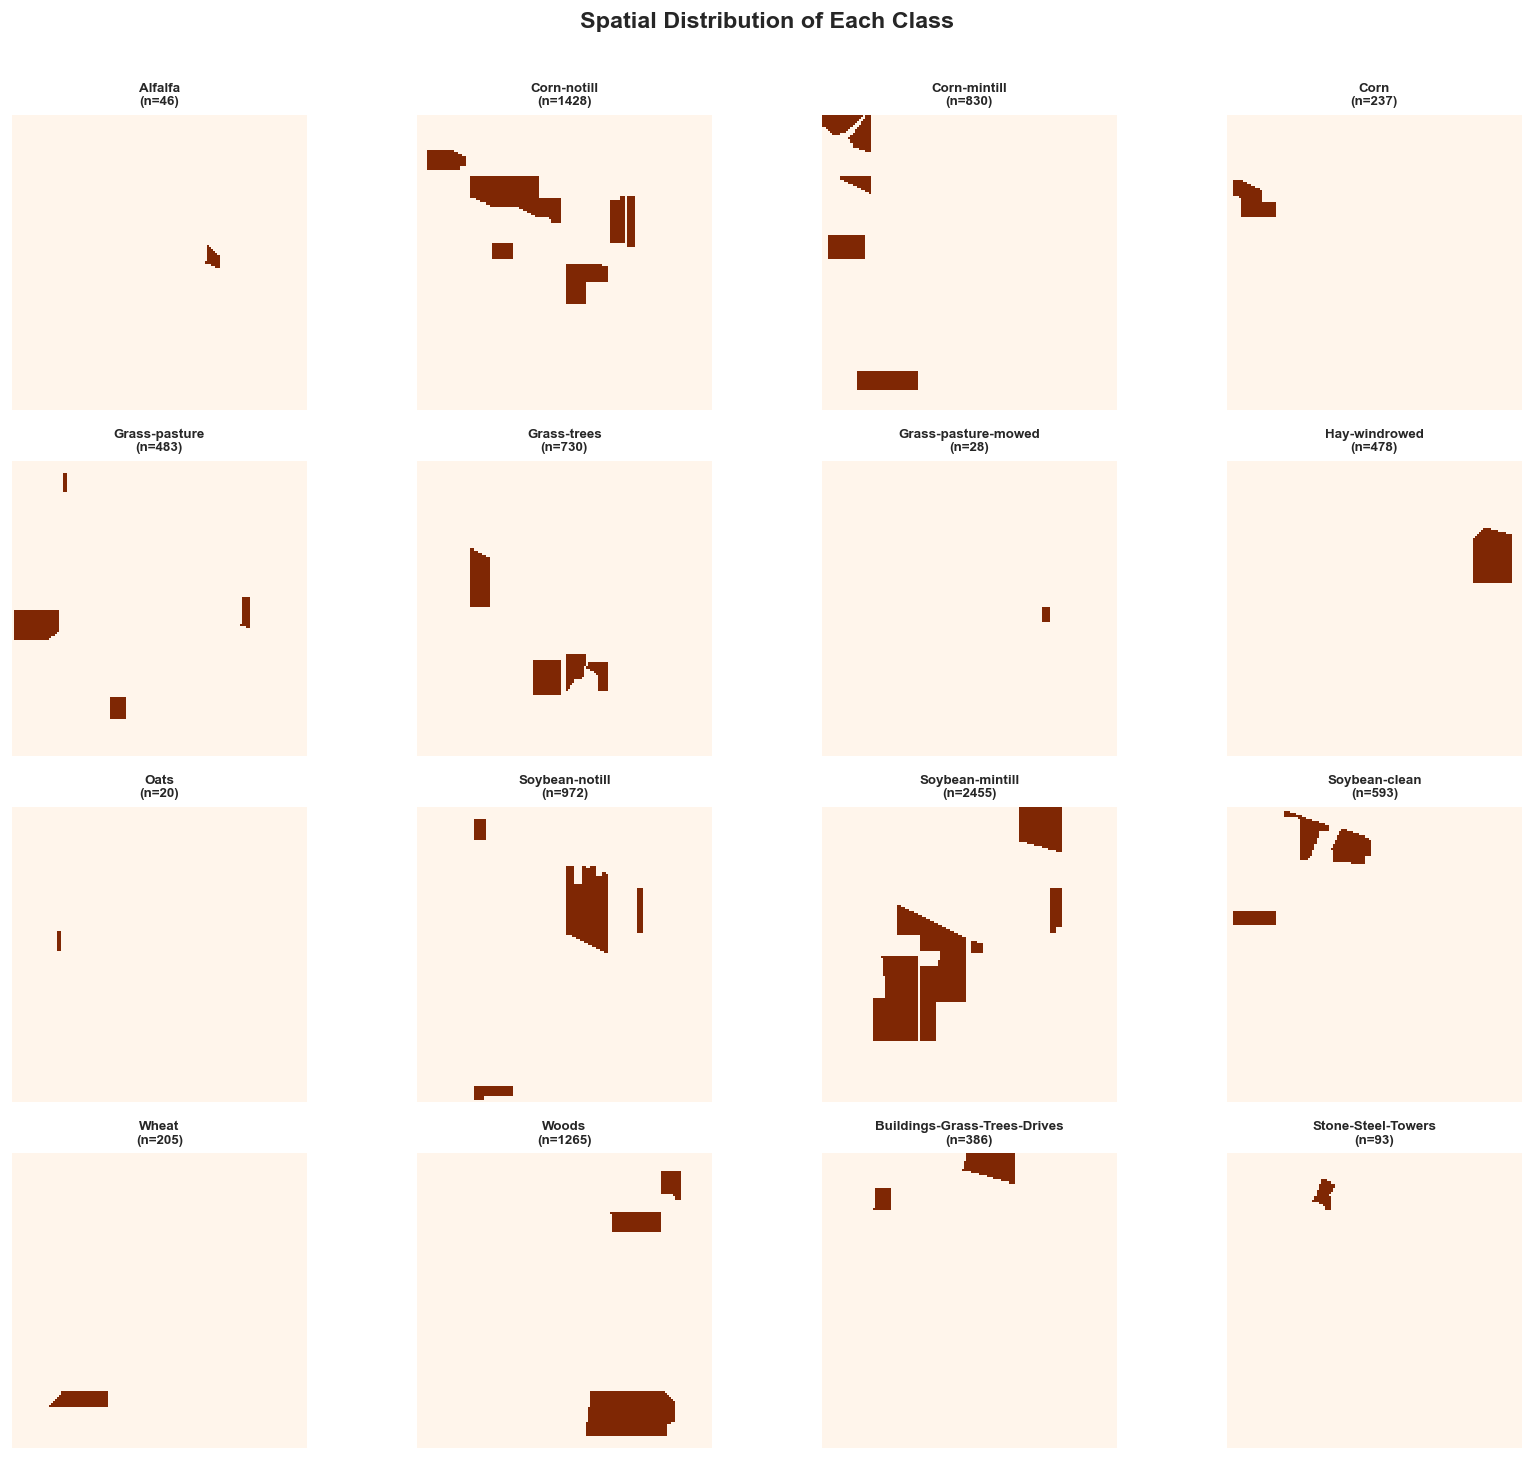

In [24]:
def plot_class_spatial(gt, class_names, ncols=4):
    """Binary masks showing the spatial extent of each class."""
    labels = sorted([c for c in np.unique(gt) if c > 0])
    n = len(labels)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.5 * ncols, 3 * nrows))
    axes = np.atleast_2d(axes)
    palette = sns.color_palette("husl", n)

    for idx, c in enumerate(labels):
        ax = axes[idx // ncols, idx % ncols]
        binary = (gt == c).astype(float)
        ax.imshow(binary, cmap="Oranges", interpolation="nearest", vmin=0, vmax=1)
        ax.set_title(f"{class_names[c]}\n(n={int(binary.sum())})", fontsize=8, fontweight="bold")
        ax.axis("off")
    for idx in range(n, nrows * ncols):
        axes[idx // ncols, idx % ncols].set_visible(False)
    fig.suptitle("Spatial Distribution of Each Class", fontsize=14, fontweight="bold", y=1.01)
    plt.tight_layout()
    plt.show()

plot_class_spatial(gt, class_names)

#### 3.5 — Inter-Band Correlation Matrix

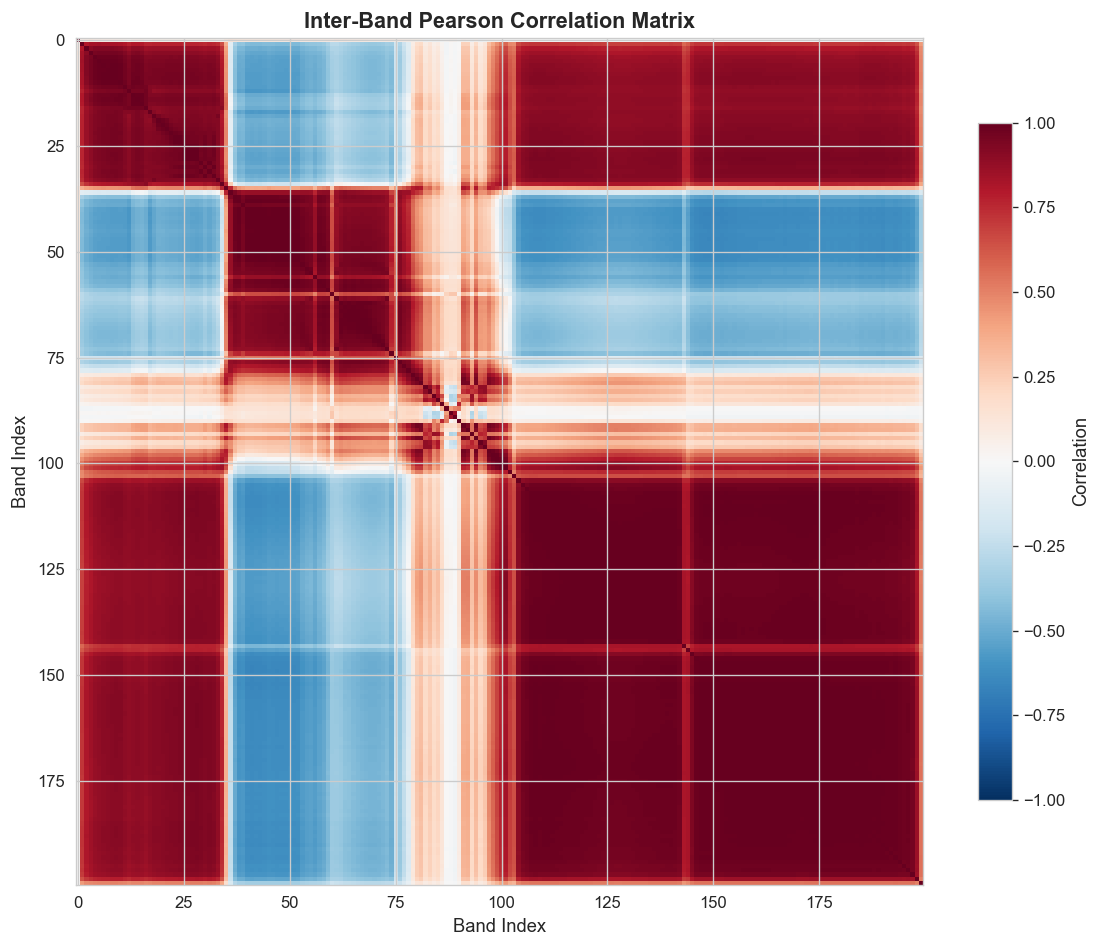

Bands with r > 0.99: 1729 pairs → high redundancy, motivates dimensionality reduction.


In [25]:
def plot_band_correlation(X, max_bands=200):
    """Pearson correlation heatmap between spectral bands."""
    flat = X.reshape(-1, X.shape[2])
    if flat.shape[1] > max_bands:
        idx = np.linspace(0, flat.shape[1] - 1, max_bands, dtype=int)
        flat = flat[:, idx]
    corr = np.corrcoef(flat.T)

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr, cmap="RdBu_r", vmin=-1, vmax=1, interpolation="nearest")
    ax.set_title("Inter-Band Pearson Correlation Matrix", fontweight="bold", fontsize=13)
    ax.set_xlabel("Band Index")
    ax.set_ylabel("Band Index")
    plt.colorbar(im, ax=ax, shrink=0.8, label="Correlation")
    plt.tight_layout()
    plt.show()

    # Identify highly correlated band groups (>0.99)
    high_corr_pairs = np.argwhere((corr > 0.99) & (np.arange(corr.shape[0])[:, None] < np.arange(corr.shape[1])))
    print(f"Bands with r > 0.99: {len(high_corr_pairs)} pairs → high redundancy, motivates dimensionality reduction.")

plot_band_correlation(X)

---
### 4 · Advanced Techniques

#### 4.1 — Signal-to-Noise Ratio (SNR) Estimation

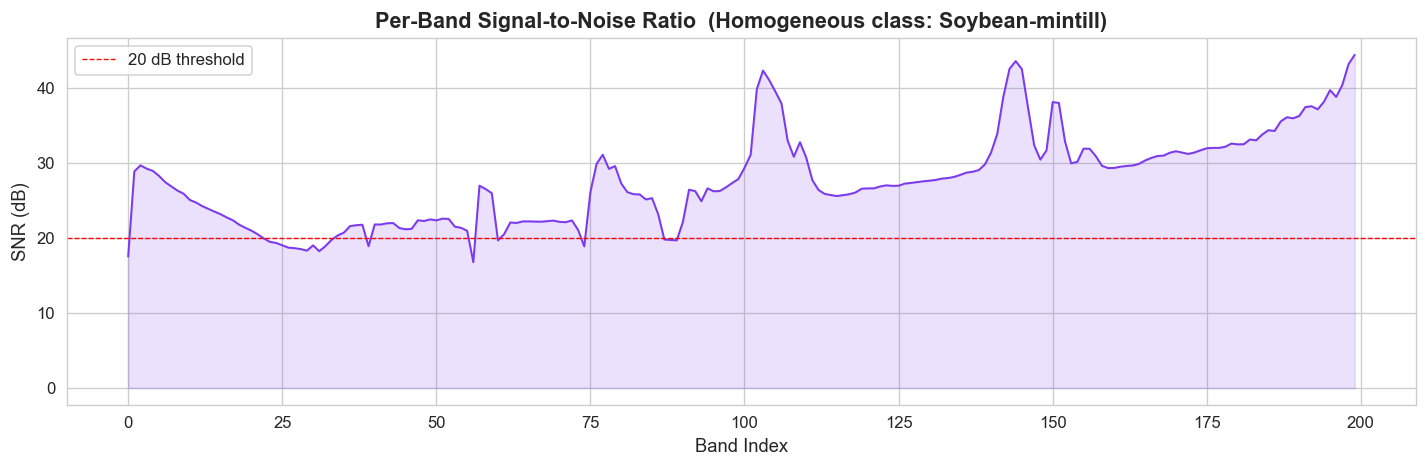

Bands with SNR < 20 dB: 20/200  — candidates for removal or stronger filtering.


In [26]:
def estimate_snr_per_band(X, gt=None, homogeneous_class=None):
    """
    Estimate per-band SNR using the homogeneous-region method.
    If a class label is given, use pixels of that class as the homogeneous region.
    Otherwise use the largest class.
    """
    if homogeneous_class is None and gt is not None:
        unique, counts = np.unique(gt[gt > 0], return_counts=True)
        homogeneous_class = unique[np.argmax(counts)]

    mask = gt == homogeneous_class
    region = X[mask]  # (n, B)

    signal_power = region.mean(axis=0) ** 2
    noise_power = region.var(axis=0) + 1e-12
    snr_db = 10 * np.log10(signal_power / noise_power)
    return snr_db, homogeneous_class

snr_db, snr_class = estimate_snr_per_band(X, gt)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(snr_db, color="#7C3AED", linewidth=1.2)
ax.fill_between(np.arange(len(snr_db)), snr_db, alpha=0.15, color="#7C3AED")
ax.axhline(y=20, color="red", linestyle="--", linewidth=0.8, label="20 dB threshold")
ax.set_xlabel("Band Index")
ax.set_ylabel("SNR (dB)")
ax.set_title(f"Per-Band Signal-to-Noise Ratio  (Homogeneous class: {class_names[snr_class]})",
             fontweight="bold")
ax.legend()
plt.tight_layout()
plt.show()

low_snr = np.sum(snr_db < 20)
print(f"Bands with SNR < 20 dB: {low_snr}/{B}  — candidates for removal or stronger filtering.")

#### 4.2 — PCA Variance Explained (Scree Plot)

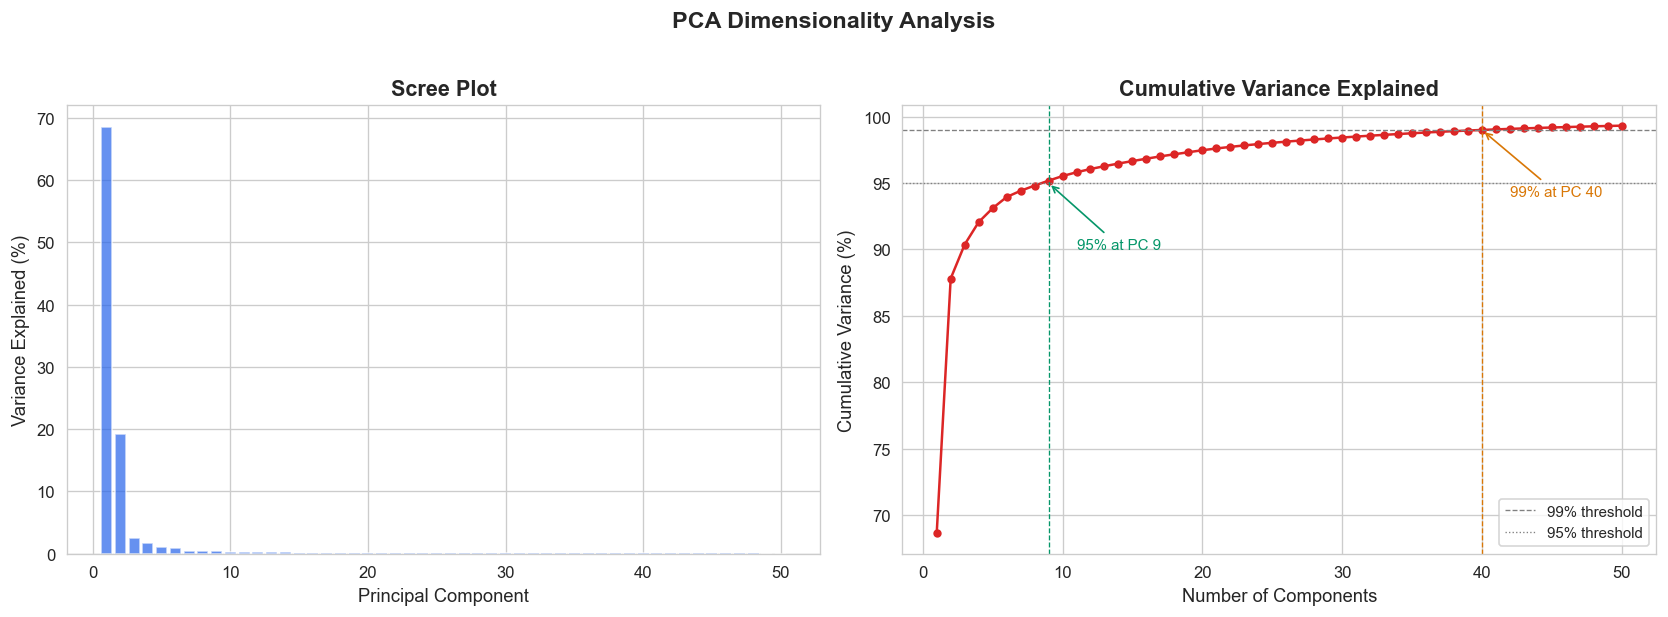

Components for 95% variance: 9
Components for 99% variance: 40


In [27]:
def plot_pca_scree(X, max_components=50):
    """Scree plot and cumulative variance to motivate dimensionality reduction."""
    flat = X.reshape(-1, X.shape[2])
    # Standardize before PCA
    scaler = StandardScaler()
    flat_scaled = scaler.fit_transform(flat)

    pca = PCA(n_components=min(max_components, X.shape[2]))
    pca.fit(flat_scaled)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Scree plot
    ax1.bar(range(1, len(explained) + 1), explained * 100, color="#2563EB", alpha=0.7)
    ax1.set_xlabel("Principal Component")
    ax1.set_ylabel("Variance Explained (%)")
    ax1.set_title("Scree Plot", fontweight="bold")

    # Cumulative
    ax2.plot(range(1, len(cumulative) + 1), cumulative * 100, "o-",
             color="#DC2626", markersize=4, linewidth=1.5)
    ax2.axhline(y=99, color="gray", linestyle="--", linewidth=0.8, label="99% threshold")
    ax2.axhline(y=95, color="gray", linestyle=":", linewidth=0.8, label="95% threshold")

    # Annotate where 95% and 99% are reached
    n95 = np.searchsorted(cumulative, 0.95) + 1
    n99 = np.searchsorted(cumulative, 0.99) + 1
    ax2.axvline(n95, color="#059669", linestyle="--", linewidth=0.8)
    ax2.axvline(n99, color="#D97706", linestyle="--", linewidth=0.8)
    ax2.annotate(f"95% at PC {n95}", (n95, 95), fontsize=9, color="#059669",
                 xytext=(n95 + 2, 90), arrowprops=dict(arrowstyle="->", color="#059669"))
    ax2.annotate(f"99% at PC {n99}", (n99, 99), fontsize=9, color="#D97706",
                 xytext=(n99 + 2, 94), arrowprops=dict(arrowstyle="->", color="#D97706"))

    ax2.set_xlabel("Number of Components")
    ax2.set_ylabel("Cumulative Variance (%)")
    ax2.set_title("Cumulative Variance Explained", fontweight="bold")
    ax2.legend(fontsize=9)

    fig.suptitle("PCA Dimensionality Analysis", fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()

    print(f"Components for 95% variance: {n95}")
    print(f"Components for 99% variance: {n99}")
    return pca

pca_model = plot_pca_scree(X)

#### 4.3 — t-SNE Embedding of Labeled Pixels

Running t-SNE on 3000 samples (PCA-30 → 2D) ...


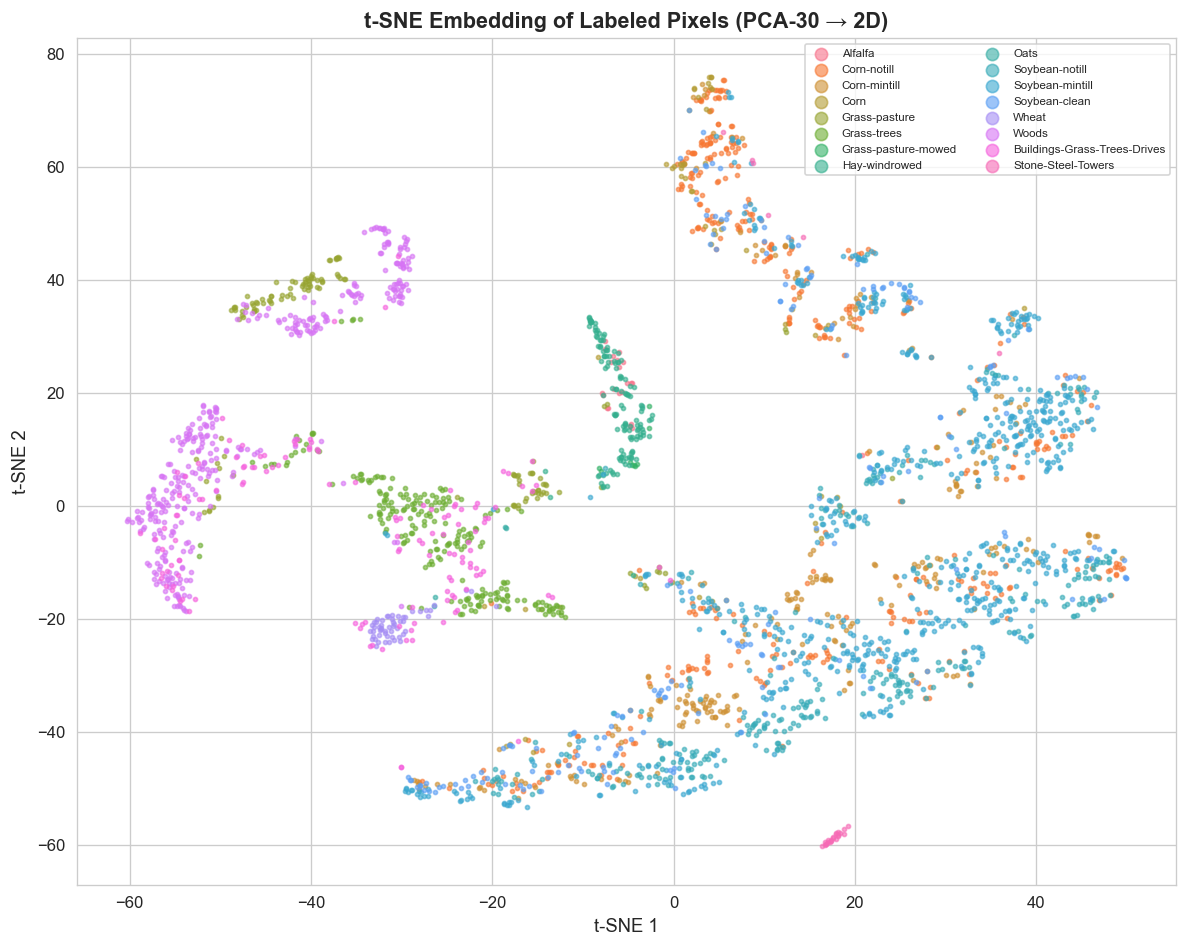

In [28]:
def plot_tsne_embedding(X, gt, class_names, n_samples=3000, perplexity=30, random_state=42):
    """2D t-SNE embedding of a subsample of labeled pixels, colored by class."""
    # Extract labeled pixels
    mask = gt > 0
    pixels = X[mask]  # (N_labeled, B)
    labels = gt[mask]

    # Subsample if too many
    if len(pixels) > n_samples:
        rng = np.random.RandomState(random_state)
        idx = rng.choice(len(pixels), n_samples, replace=False)
        pixels = pixels[idx]
        labels = labels[idx]

    # Standardize
    scaler = StandardScaler()
    pixels_scaled = scaler.fit_transform(pixels)

    # PCA to 30 dims first (recommended before t-SNE)
    pca = PCA(n_components=30, random_state=random_state)
    pixels_pca = pca.fit_transform(pixels_scaled)

    # t-SNE
    print(f"Running t-SNE on {len(pixels)} samples (PCA-30 → 2D) ...")
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state,
                max_iter=1000, init="pca", learning_rate="auto")
    embedding = tsne.fit_transform(pixels_pca)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    unique_labels = sorted(np.unique(labels))
    palette = sns.color_palette("husl", len(unique_labels))

    for idx_l, c in enumerate(unique_labels):
        m = labels == c
        ax.scatter(embedding[m, 0], embedding[m, 1], s=6, alpha=0.6,
                   color=palette[idx_l], label=class_names[c])

    ax.set_title("t-SNE Embedding of Labeled Pixels (PCA-30 → 2D)", fontweight="bold", fontsize=13)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.legend(fontsize=7, ncol=2, loc="best", markerscale=3, frameon=True)
    plt.tight_layout()
    plt.show()

plot_tsne_embedding(X, gt, class_names)

#### 4.4 — Spatial Heterogeneity Preview (Local Moran's I)

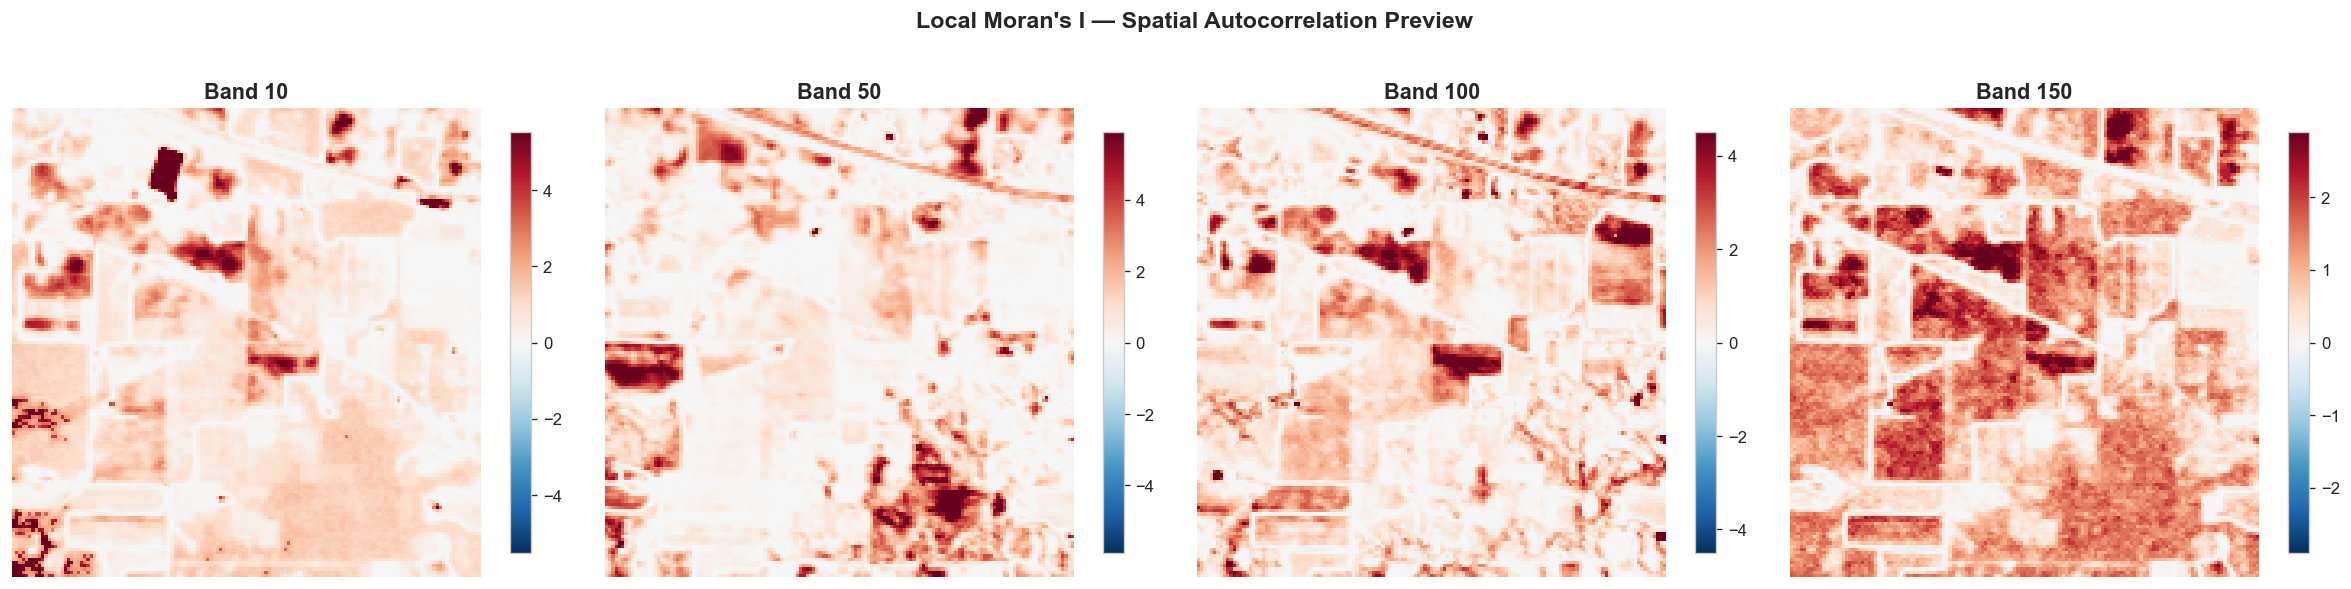

Red = positive spatial autocorrelation (similar neighbors)
Blue = negative (dissimilar neighbors)
→ Motivates spatial feature engineering & spatial-spectral models.


In [29]:
def compute_local_morans_I(band_image, w_size=3):
    """
    Compute Local Moran's I for a single band image.
    Uses a simple queen contiguity (moving window) approach.
    """
    n = band_image.size
    x = band_image.astype(np.float64)
    x_mean = x.mean()
    z = x - x_mean
    s2 = (z ** 2).mean()

    # Spatial lag via uniform filter (queen contiguity approximation)
    kernel = np.ones((w_size, w_size))
    kernel[w_size // 2, w_size // 2] = 0  # exclude center
    n_neighbors = ndimage.uniform_filter(np.ones_like(x), size=w_size, mode="constant") * w_size**2 - 1
    spatial_lag = ndimage.convolve(z, kernel, mode="constant") / (n_neighbors + 1e-12)

    local_I = z * spatial_lag / (s2 + 1e-12)
    return local_I

# Compute for a few representative bands
moran_bands = [10, 50, 100, 150]
fig, axes = plt.subplots(1, len(moran_bands), figsize=(5 * len(moran_bands), 5))
for ax, b_idx in zip(axes, moran_bands):
    local_I = compute_local_morans_I(X[:, :, b_idx])
    im = ax.imshow(local_I, cmap="RdBu_r", interpolation="nearest",
                   vmin=-np.percentile(np.abs(local_I), 99),
                   vmax=np.percentile(np.abs(local_I), 99))
    ax.set_title(f"Band {b_idx}", fontweight="bold")
    ax.axis("off")
    plt.colorbar(im, ax=ax, shrink=0.8)

fig.suptitle("Local Moran's I — Spatial Autocorrelation Preview", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

print("Red = positive spatial autocorrelation (similar neighbors)")
print("Blue = negative (dissimilar neighbors)")
print("→ Motivates spatial feature engineering & spatial-spectral models.")

#### 4.5 — Spectral Derivative Analysis

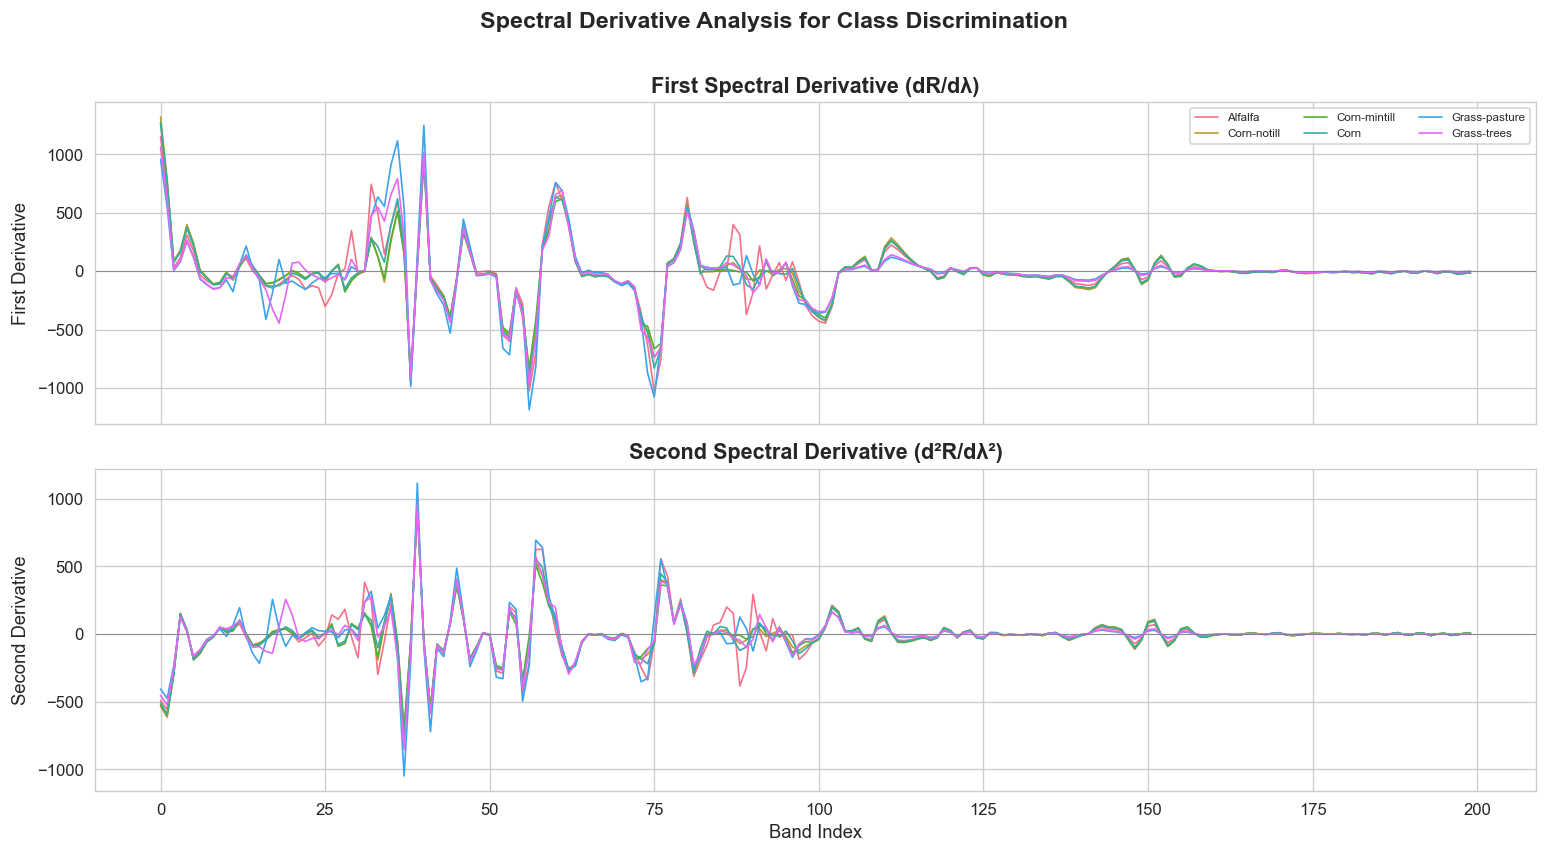

In [30]:
def plot_spectral_derivatives(class_spectra, classes_to_show=None):
    """First and second derivative of mean spectral signatures for class discrimination."""
    if classes_to_show is None:
        classes_to_show = list(class_spectra.keys())[:6]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7), sharex=True)
    palette = sns.color_palette("husl", len(classes_to_show))

    for idx, c in enumerate(classes_to_show):
        info = class_spectra[c]
        mean_spec = info["mean"]
        first_deriv = np.gradient(mean_spec)
        second_deriv = np.gradient(first_deriv)

        ax1.plot(first_deriv, color=palette[idx], linewidth=1.0, label=info["name"])
        ax2.plot(second_deriv, color=palette[idx], linewidth=1.0, label=info["name"])

    ax1.set_ylabel("First Derivative")
    ax1.set_title("First Spectral Derivative (dR/dλ)", fontweight="bold")
    ax1.legend(fontsize=7, ncol=3)
    ax1.axhline(0, color="gray", linewidth=0.5)

    ax2.set_ylabel("Second Derivative")
    ax2.set_xlabel("Band Index")
    ax2.set_title("Second Spectral Derivative (d²R/dλ²)", fontweight="bold")
    ax2.axhline(0, color="gray", linewidth=0.5)

    fig.suptitle("Spectral Derivative Analysis for Class Discrimination",
                 fontsize=14, fontweight="bold", y=1.01)
    plt.tight_layout()
    plt.show()

plot_spectral_derivatives(class_spectra)

#### 4.6 — Jeffries-Matusita (JM) Distance — Pairwise Class Separability

Computing JM distances (this may take a moment) ...


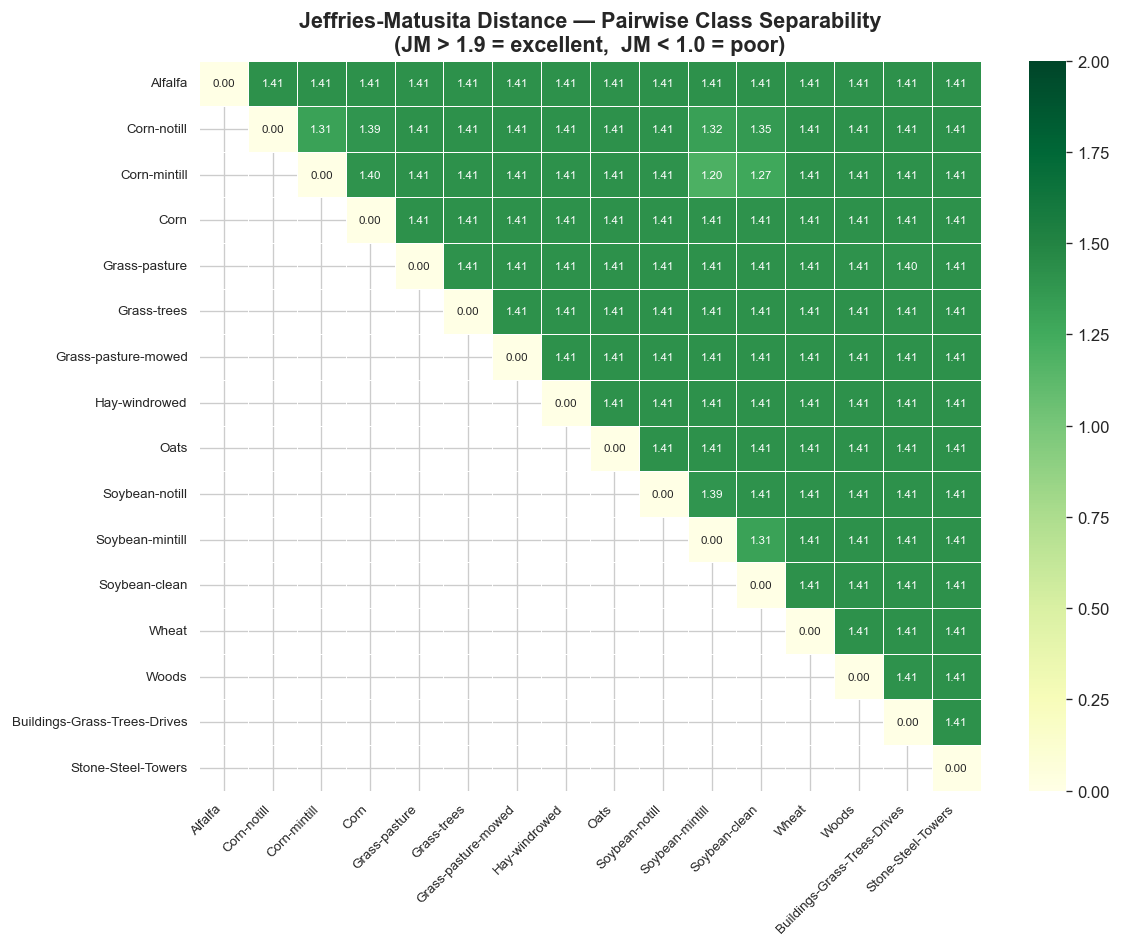

✅ All class pairs are reasonably separable (JM ≥ 1.0).


In [31]:
def jeffries_matusita_distance(mean1, cov1, mean2, cov2):
    """
    Compute JM distance between two classes assuming Gaussian distributions.
    JM ∈ [0, 2]. Values > 1.9 indicate excellent separability.
    """
    diff = (mean1 - mean2).reshape(-1, 1)
    cov_avg = (cov1 + cov2) / 2.0

    # Bhattacharyya distance
    try:
        cov_avg_inv = np.linalg.pinv(cov_avg)
        term1 = 0.125 * diff.T @ cov_avg_inv @ diff
        sign1, logdet_avg = np.linalg.slogdet(cov_avg)
        sign2, logdet1 = np.linalg.slogdet(cov1)
        sign3, logdet2 = np.linalg.slogdet(cov2)
        term2 = 0.5 * (logdet_avg - 0.5 * (logdet1 + logdet2))
        bhatt = float((term1 + term2).item())
    except np.linalg.LinAlgError:
        return np.nan

    jm = 2.0 * (1.0 - np.exp(-bhatt))
    return np.sqrt(max(jm, 0))

def compute_jm_matrix(X, gt, class_names, max_bands_pca=30):
    """Compute pairwise JM distance matrix (works in PCA space if many bands)."""
    labels = sorted([c for c in np.unique(gt) if c > 0])
    n = len(labels)

    # Project to PCA space for numerical stability
    mask = gt > 0
    flat_labeled = X[mask]
    flat_labels = gt[mask]

    scaler = StandardScaler()
    flat_scaled = scaler.fit_transform(flat_labeled)
    pca = PCA(n_components=min(max_bands_pca, X.shape[2]))
    flat_pca = pca.fit_transform(flat_scaled)

    # Compute per-class statistics in PCA space
    stats = {}
    for c in labels:
        m = flat_labels == c
        data_c = flat_pca[m]
        stats[c] = {
            "mean": data_c.mean(axis=0),
            "cov": np.cov(data_c.T) + np.eye(flat_pca.shape[1]) * 1e-6,
        }

    jm_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            jm = jeffries_matusita_distance(
                stats[labels[i]]["mean"], stats[labels[i]]["cov"],
                stats[labels[j]]["mean"], stats[labels[j]]["cov"],
            )
            jm_mat[i, j] = jm_mat[j, i] = jm

    names = [class_names[c] for c in labels]
    return jm_mat, names

print("Computing JM distances (this may take a moment) ...")
jm_mat, jm_names = compute_jm_matrix(X, gt, class_names)

fig, ax = plt.subplots(figsize=(10, 8))
mask_tri = np.triu(np.ones_like(jm_mat, dtype=bool), k=1)
sns.heatmap(jm_mat, annot=True, fmt=".2f",
            mask=~mask_tri & ~np.eye(len(jm_mat), dtype=bool),
            xticklabels=jm_names, yticklabels=jm_names,
            cmap="YlGn", ax=ax, linewidths=0.5, vmin=0, vmax=2,
            annot_kws={"fontsize": 7})
ax.set_title("Jeffries-Matusita Distance — Pairwise Class Separability\n"
             "(JM > 1.9 = excellent,  JM < 1.0 = poor)", fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Identify poorly separable pairs
poor_pairs = []
for i in range(len(jm_names)):
    for j in range(i + 1, len(jm_names)):
        if jm_mat[i, j] < 1.0:
            poor_pairs.append((jm_names[i], jm_names[j], jm_mat[i, j]))
if poor_pairs:
    print("\n⚠️  Poorly separable class pairs (JM < 1.0):")
    for a, b, d in sorted(poor_pairs, key=lambda x: x[2]):
        print(f"   {a}  ↔  {b}  :  JM = {d:.3f}")
else:
    print("✅ All class pairs are reasonably separable (JM ≥ 1.0).")

---
### 5 · Summary & Key Findings

| Topic | Key Observation |
|---|---|
| **Dataset shape** | 145 × 145 × 200 bands |
| **Class count** | 16 classes + background |
| **Class imbalance** | Significant — some classes have < 30 samples (Oats, Grass-pasture-mowed) |
| **Band redundancy** | Very high inter-band correlation → strong case for PCA / MNF |
| **SNR** | Some low-SNR bands → candidates for removal |
| **Spectral separability** | Several class pairs are spectrally similar (SAM & JM) → spatial features needed |
| **Spatial autocorrelation** | Visible in Moran's I → spatial-spectral approaches recommended |

**Next Steps:**
- `01_dimensionality_reduction.ipynb` — PCA, MNF, feature selection based on findings above
- `02_spatial_autocorrelation.ipynb` — Full Moran's I, LISA, spatial weights analysis
- `03_feature_engineering.ipynb` — Morphological profiles, texture features, spectral indices

In [32]:
print("=" * 60)
print("  EDA & Visualization complete of Pavia University dataset.")
print("  Proceed to dimensionality reduction & feature engineering.")
print("=" * 60)

  EDA & Visualization complete of Indian Pines dataset.
  Proceed to dimensionality reduction & feature engineering.
